# Fairness Exemplo 1

Ideia: Criar um Modelo de Predição simples a partir da base de dados "adult.csv" e checar de alguma forma se a restrição de independência está sendo cumprida para o atributo sensível RAÇA.

Independência: P{R = 1; A = a} = P{R = 1; A = b}; Para todo grupo a e b

Primeiro vou fazer um modelo simples, só inserindo tudo. Aparentemente a base já veio com tratamento de nulos, então provavelmente já foi feito um pré-processamento.
Basicamente procuro checar as 3 principais Restrições de Group Fairness para esse Dataset, e também mostrar que simplesmente excluir o Atr.Prot. não causa tanto impacto no Fairness em si.

Importando as bibliotecas principais e recebendo os dados.

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv(".\\adult.csv")
data = data.drop('native-country', axis = 1)
data = data.drop('education', axis = 1) # excluindo isso pq já temos a equivalente numérica educational-num
data.info()
categoricalLabels = ((data.drop('income', axis = 1)).select_dtypes(include = ['object'])).columns

print(categoricalLabels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   educational-num  48842 non-null  int64 
 4   marital-status   48842 non-null  object
 5   occupation       48842 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   gender           48842 non-null  object
 9   capital-gain     48842 non-null  int64 
 10  capital-loss     48842 non-null  int64 
 11  hours-per-week   48842 non-null  int64 
 12  income           48842 non-null  object
dtypes: int64(6), object(7)
memory usage: 4.8+ MB
Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender'],
      dtype='object')


Separando os dados entre X e Y, onde Y é a variável alvo.
Após isso faço um split para termos os dados de teste e os de treino. Fixo um random_state para checar melhor os resultados.

In [83]:
x = data.drop(['income'], axis=1)
Y = data["income"]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.3)
x_train.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week
36389,43,Private,223277,10,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40
46865,18,?,51574,9,Never-married,?,Own-child,Asian-Pac-Islander,Female,0,1602,38
9539,29,Private,377414,12,Divorced,Tech-support,Not-in-family,White,Female,0,0,40
35110,27,Private,187746,10,Never-married,Other-service,Own-child,White,Female,0,0,40
31321,25,State-gov,156848,9,Married-civ-spouse,Protective-serv,Own-child,White,Male,0,0,35


Utilizo um Ordinal Encoder em todas as minhas variáveis categóricas presente em X, tanto em X-Treino como X-Teste.
Após fazer isso, eu faço uma coisa parecida com a variável alvo, basicamente torno ela um valor binário(1 ou 0).

In [84]:
categoricalLabels = (x_train.select_dtypes(include = ['object'])).columns

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse = False, categories = "auto", dtype='int8') # Criando um Codificador
    
OHtrain = pd.DataFrame(encoder.fit_transform(x_train[categoricalLabels])) # Fazendo o treino de codificação inicial
columns = encoder.get_feature_names_out(categoricalLabels) # Para manter o nome das Features no OneHotEncoder eu capturo o nome das Features aqui
OHtrain.columns = columns # Mudo as Colunas para os Nomes capturados antes

OHtest = pd.DataFrame(encoder.transform(x_test[categoricalLabels])) # Repete o processo pro test
columns = encoder.get_feature_names_out(categoricalLabels)
OHtest.columns = columns

OHtrain.index = x_train.index # Atualizando os indices
OHtest.index = x_test.index

old_x_train = x_train[categoricalLabels] # Salva as Features antes do Pré-Processamento para utilizar depois na construção do gráfico
old_x_test = x_test[categoricalLabels]

num_x_train = x_train.drop(categoricalLabels, axis = 1) # Apaga as Features que serão substituidas pelas colunas codificadas
num_x_test = x_test.drop(categoricalLabels, axis = 1)

num_x_train = pd.concat([num_x_train, OHtrain], axis = 1) # Junta o DataSet com as novas Features codificadas
num_x_test = pd.concat([num_x_test, OHtest], axis = 1)
    
num_y_train = y_train.apply(lambda p: 1 if p == '>50K' else 0) # Codifica o Y em Booleano, mantive
num_y_test = y_test.apply(lambda p: 1 if p == '>50K' else 0)

# Classificador (Árvore de Decisão) 
Após isso, faço o modelo propriamente dito, utilizo um Classificador de Árvore de decisão e efetuo a predição, fixo um random_state para ter o mesmo MAE, mas o valor do MAE é cerca de 0.18, variando um pouco pra mais ou pra menos.

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

modelo = DecisionTreeClassifier()

modelo.fit(num_x_train, num_y_train)
previsao = modelo.predict(num_x_test)

acuraciaNP = mean_absolute_error(num_y_test, previsao)

print(acuraciaNP)

0.19190609431515732


Aqui vem a parte final. Checar a independência, como não sei uma forma de quantificar tudo isso resolvi fazer essa checagem por meio de gráficos. Um gráfico que mostra a proporção de pessoas que são classificadas, como positivas ou negativas, separadas por raça.

Primeiro eu inverto a transformação feita antes nas variáveis categóricas, após isso eu junto o X-Teste com a Previsão com os valores de Ŷ, que são os Y's do Classificador.
Após isso eu seleciono apenas os Atributos Raça e o Ŷ. Depois eu agrupo os dados a partir do Ŷ e conto os valores separados por raça.
Com isso, eu conto os valores apenas por Raça, para saber quantas pessoas eu tenho de cada Raça. Então eu faça uma Junção para ter um registro formado por:

Ŷ - Raça - Quantidade de Ŷ para aquela raça - Quantidade de Pessoas daquela raça.

OBS: Não sei se fazer essa junção era a maneira mais fácil de fazer o que eu fiz, mas foi a única que lembrei como fazer, talvez encontre uma forma melhor e mais rápida depois.

Para finalizar eu reverto a codificação binária que fiz no Y, e obtenho a Proporção de Ŷ para aquela raça a partir de:

(Quantidade de Ŷ para aquela raça) / (Quantidade de Pessoas daquela raça).

In [86]:
df = x_test.copy()
print(df.head())

df["previsao"] = previsao
df = df[["race", "previsao"]]
hue = "previsao"
print(df.head())
dfe = pd.DataFrame(df.groupby('previsao').value_counts().rename("count").reset_index())

dfd = df["race"].value_counts()
dfd = dfd.reset_index()
dfe = dfe.merge(dfd, left_on='race', right_on='index')
dfe = dfe.drop("index", axis = 1)

dfe = dfe.rename(columns = {"race_x": "race", "race_y": "total"})
dfe["proportion"] = dfe["count"]/dfe["total"]*100

dfe['previsao'] = dfe["previsao"].apply(lambda p: '>50K' if p == 1 else '<=50K')

       age    workclass  fnlwgt  educational-num      marital-status  \
1682    26      Private  427744                9       Never-married   
32501   36      Private  175759               13  Married-civ-spouse   
34157   64            ?   45817                5  Married-civ-spouse   
46497   55      Private  227856               13  Married-civ-spouse   
14562   34  Federal-gov  168931               13  Married-civ-spouse   

            occupation relationship   race  gender  capital-gain  \
1682      Adm-clerical    Own-child  White    Male             0   
32501  Exec-managerial      Husband  White    Male          7298   
34157                ?      Husband  White    Male             0   
46497  Exec-managerial      Husband  White    Male          7298   
14562  Exec-managerial         Wife  Other  Female             0   

       capital-loss  hours-per-week  
1682              0              40  
32501             0              50  
34157             0              50  
46497 

# Classificador (Árvore de Decisão) Protegido
A Partir daqui repito os passos para o Modelo Protegido

In [87]:
num_x_trainProtected = num_x_train.drop(['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White'], axis = 1)
num_x_testProtected = num_x_test.drop(['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White'], axis = 1) 

In [88]:
modeloProtected = DecisionTreeClassifier()

modeloProtected.fit(num_x_trainProtected, num_y_train)
previsaoProtected = modeloProtected.predict(num_x_testProtected)

acuraciaP = mean_absolute_error(num_y_test, previsaoProtected)
print(acuraciaP)

0.18815259673786938


In [89]:
dfProtected = x_test.copy()

dfProtected["previsao"] = previsaoProtected
dfProtected = dfProtected[["race", "previsao"]]
hue = "previsao"

dfeProtected = pd.DataFrame(dfProtected.groupby('previsao').value_counts().rename("count").reset_index())

dfdProtected = dfProtected["race"].value_counts()
dfdProtected = dfdProtected.reset_index()
dfeProtected = dfeProtected.merge(dfdProtected, left_on='race', right_on='index')
dfeProtected = dfeProtected.drop("index", axis = 1)

dfeProtected = dfeProtected.rename(columns = {"race_x": "race", "race_y": "total"})
dfeProtected["proportion"] = dfeProtected["count"]/dfeProtected["total"]*100

dfeProtected['previsao'] = dfeProtected["previsao"].apply(lambda p: '>50K' if p == 1 else '<=50K')

### Restrição de "Statistical Parity"
Checagem da Restrição de Paridade Estatística para esse Modelo.

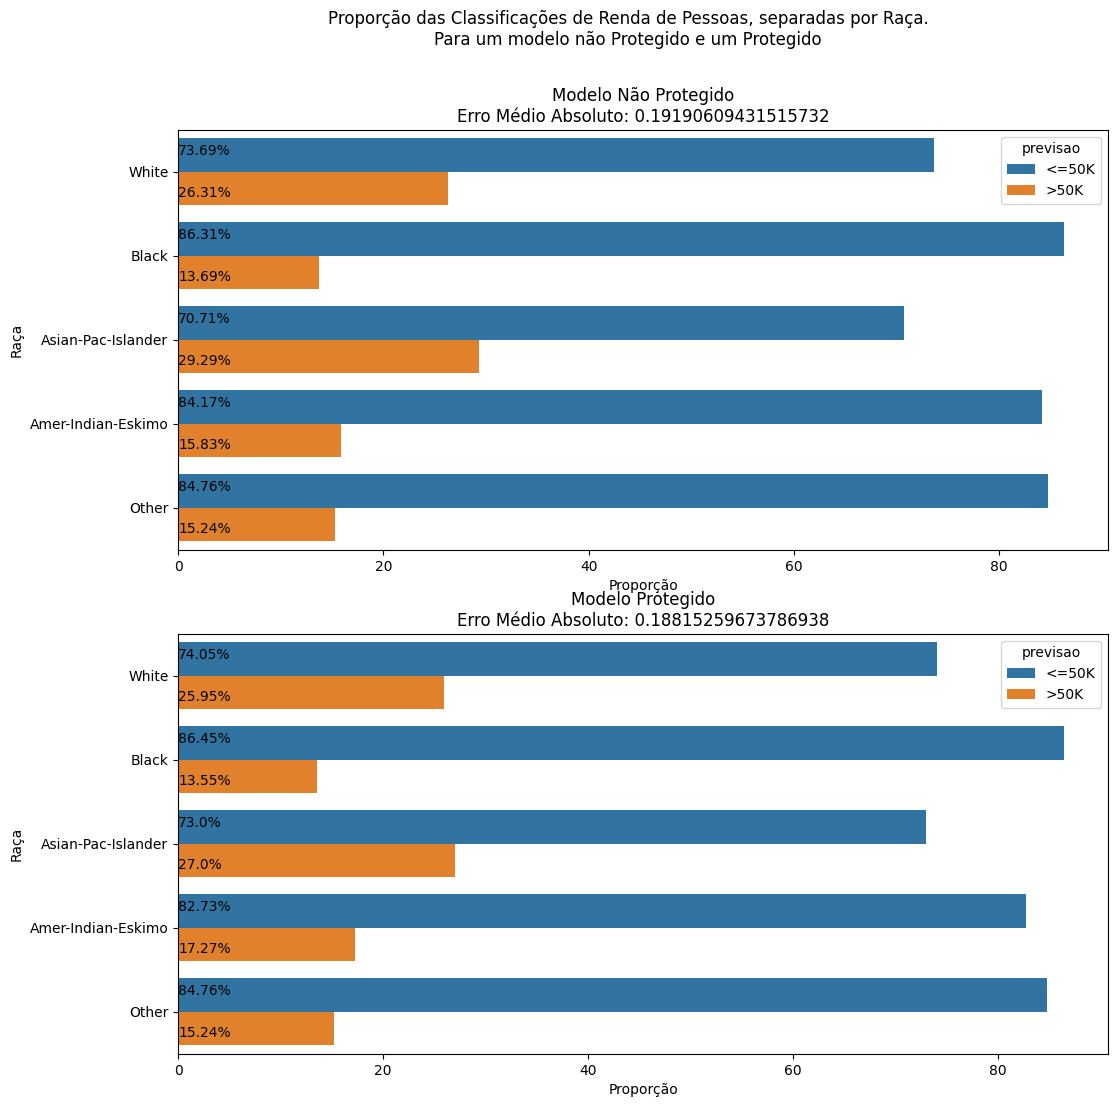

In [90]:
fig, ax = plt.subplots(2, 1, figsize = (12, 12))
fig.suptitle("Proporção das Classificações de Renda de Pessoas, separadas por Raça.\nPara um modelo não Protegido e um Protegido")

plot = sns.barplot(ax = ax[0], data = dfe,x = "proportion", y = "race", hue = "previsao")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")

for index, row in dfe.iterrows():
    plot.text(0, (row.name)/2 - 0.2, str(round(row.proportion, 2)) + "%",color='black')
    
plot1 = sns.barplot(ax = ax[1], data = dfeProtected,x = "proportion", y = "race", hue = "previsao")
plot1.set_ylabel("Raça")
plot1.set_xlabel("Proporção")

for index, row in dfeProtected.iterrows():
    plot1.text(0, (row.name)/2 - 0.2, str(round(row.proportion, 2)) + "%",color='black')

ax[0].set_title("Modelo Não Protegido\nErro Médio Absoluto: " + str(acuraciaNP))
ax[1].set_title("Modelo Protegido\nErro Médio Absoluto: " + str(acuraciaP))
plt.show()
fig.savefig("output1.png")

### Restrição de "Equalized Odds"

In [91]:
newdata = pd.DataFrame()
newdata['race'] = x_test['race'].copy()
newdata['previsao'] = previsaoProtected.copy()
newdata['income'] = num_y_test.copy()

In [92]:
races = newdata['race'].unique()
tabela = pd.DataFrame(columns = ['Race', 'Valor', 'Tipo'])

for race in races:
    groupedRaces = (newdata.loc[(newdata['race'] == race)])
    crosstab = pd.crosstab(groupedRaces['previsao'], groupedRaces['income'], margins = True)

    valor = crosstab.iloc[0,0]/crosstab.iloc[2,0]
    valor2 = crosstab.iloc[1,1]/crosstab.iloc[2,1]

    tabela.loc[-1] = [race, valor, 'Rejeitado']
    tabela.index = tabela.index + 1
    tabela = tabela.sort_index()
    tabela.loc[-1] = [race, valor2, 'Aceitado']
    tabela.index = tabela.index + 1
    tabela = tabela.sort_index()

tabela['Valor'] = tabela['Valor'] * 100

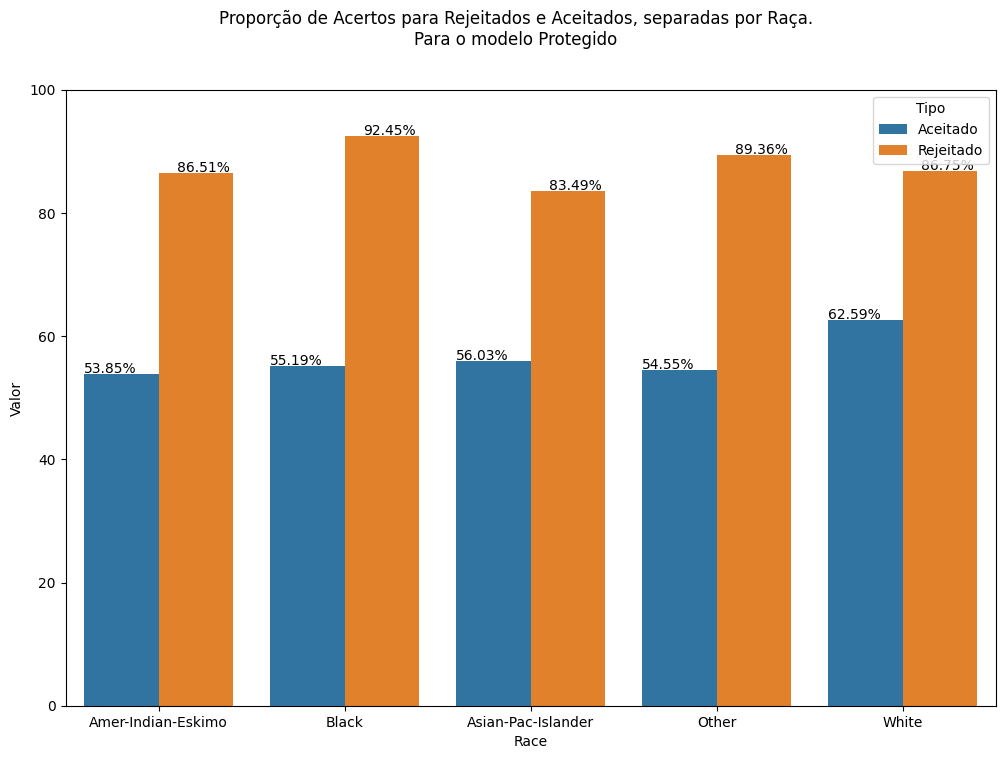

In [93]:
fig2 = plt.figure(figsize = (12, 8))
fig2.suptitle("Proporção de Acertos para Rejeitados e Aceitados, separadas por Raça.\nPara o modelo Protegido")

# plot = sns.barplot(ax2 = ax2[0], data = ,x = "proportion", y = "race", hue = "income")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")    

plot2 = sns.barplot(data = tabela, x = "Race", y = "Valor", hue = "Tipo")

for index, row in tabela.iterrows():
    plot2.text((row.name)/2 - 0.4, (row.Valor) + 0.2, str(round(row.Valor, 2)) + "%",color='black')

plt.ylim((0,100))
plt.show()
fig2.savefig("output2.png")

### Restrição de "Predictive Parity"

In [94]:
newdata = pd.DataFrame()
newdata['race'] = x_test['race'].copy()
newdata['previsao'] = previsaoProtected.copy()
newdata['income'] = num_y_test.copy()

In [95]:
races = newdata['race'].unique()
tabela1 = pd.DataFrame(columns = ['Race', 'Valor'])

for race in races:
    groupedRaces = (newdata.loc[(newdata['race'] == race)])

    valor = mean_absolute_error(groupedRaces['income'], groupedRaces['previsao'])

    tabela1.loc[-1] = [race, valor]
    tabela1.index = tabela1.index + 1
    tabela1 = tabela1.sort_index()

tabela1['Valor'] = - (tabela1['Valor'] * 100) + 100 

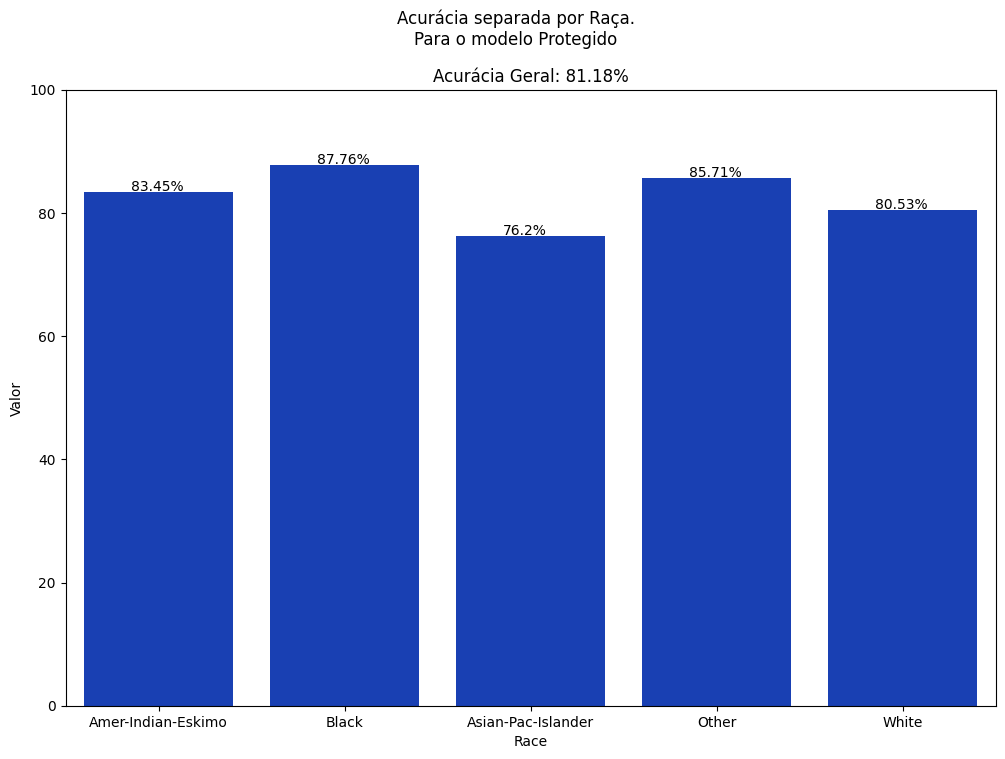

In [96]:
fig3 = plt.figure(figsize = (12, 8))
fig3.suptitle("Acurácia separada por Raça.\nPara o modelo Protegido")

# plot = sns.barplot(ax2 = ax2[0], data = ,x = "proportion", y = "race", hue = "income")
# plot.set_ylabel("Raça")
# plot.set_xlabel("Proporção")    

plot2 = sns.barplot(data = tabela1, x = "Race", y = "Valor", color = "#0033cc")

for index, row in tabela1.iterrows():
    plot2.text((row.name) - 0.15, (row.Valor) + 0.2, str(round(row.Valor, 2)) + "%",color='black')


plt.title("Acurácia Geral: " + str(round(-(acuraciaP * 100) + 100, 2)) + "%")
plt.ylim((0,100))
plt.show()
fig3.savefig("output3.png")

## Conclusão:
Os valores das Proporções, que nesse caso podem ser interpretados como Probabilidades, diferem bastante entre si, tanto no modelo protegido, quanto no não protegido, assim a restrição de Independência, ou Paridade Estatística, não estão sendo atendidas por esses Modelos.

OBS: Mantive as 5 raças para ter uma primeira ideia inicial melhor, na prática era melhor transformá-los em Favorecidos e Desfavorecidos, fica mais fácil na prática. Também não fiz os gráficos das outras restrições para o Modelo não protegido por quê provalvemente seriam resultados bem próximos. Esse foi o primeiro mini-projeto que fiz com Fairness então ele provavelmente tem diversos erros.